### 1 Introduction

#### 1.1 Project objective
The goal of this project is to apply data science methodologies to analyze given data from a bank related to loan defaulting and repayment. By leveraging the data, we aim to identify key factors that contribute to loan payment. Examples of factors include personal information, income, location, ect..

#### 1.2 Dataset overview
The dataset used in this project is a comprehensive collection of loan application records, sourced from Kaggle. It encompasses a wide range of attributes, including personal demographics, credit history, and loan details. <br/>
Provided files include: Loan application data, A description of the columns, Previous application data.<br/>
In this project, we will only focus on the loan application data. <br/>
The dataset contains 122 features, a lot of missing datapoints, and multiple object datatypes.

### 2 Data Loading and Initial Exploration

#### 2.1 Import Libraries, initializations, helper methods

In [230]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns



In [231]:
#pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

label_encoder = LabelEncoder()

columns_to_remove = set()

#new dataframe for holding categorical data
app_df_cat = pd.DataFrame()

In [232]:
def print_columns(dataframe):
    columns = dataframe.columns.tolist()
    print(len(columns))
    print(np.transpose(columns))

In [233]:
def print_null_values(dataframe):
    missing_values = dataframe.isnull().sum()
    missing_values = missing_values[missing_values > 0]
    percent_missing = missing_values / len(dataframe) * 100
    missing_value_df = pd.DataFrame({'Feature': missing_values.index, 'Missing Values': missing_values.values, 'Percent Missing': percent_missing.values})
    print(missing_value_df.sort_values(by='Percent Missing', ascending=False))

In [234]:
def find_outlier_columns(df, multiplier=1.5,lower=0.25, upper=0.75, exclude=[]):
    outlier_columns = []
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        if col in exclude:
            continue  # Skip the columns in the exclude list
        Q1 = df[col].quantile(lower)
        Q3 = df[col].quantile(upper)
        IQR = Q3 - Q1
        outlier_step = multiplier * IQR
        
        # Check if any value in the column is an outlier
        if ((df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)).any():
            outlier_columns.append(col)
    return outlier_columns

#### 2.2 Load the Dataset


In [235]:
app_df = pd.read_csv('data/application_data.csv')

app_df_cat = app_df.copy()

#### 2.3 Preliminary Data Summary


In [236]:
app_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [237]:
app_df[['SK_ID_CURR','TARGET','DAYS_BIRTH']].head()

,SK_ID_CURR,TARGET,DAYS_BIRTH
0,100002,1,-9461
1,100003,0,-16765
2,100004,0,-19046
3,100006,0,-19005
4,100007,0,-19932


In [238]:
app_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [239]:
app_df.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511.0,278180.518577,102790.175348,1.000020e+05,189145.500000,278202.000000,367142.500000,4.562550e+05
TARGET,307511.0,0.080729,0.272419,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
CNT_CHILDREN,307511.0,0.417052,0.722121,0.000000e+00,0.000000,0.000000,1.000000,1.900000e+01
AMT_INCOME_TOTAL,307511.0,168797.919297,237123.146279,2.565000e+04,112500.000000,147150.000000,202500.000000,1.170000e+08
AMT_CREDIT,307511.0,599025.999706,402490.776996,4.500000e+04,270000.000000,513531.000000,808650.000000,4.050000e+06
AMT_ANNUITY,307499.0,27108.573909,14493.737315,1.615500e+03,16524.000000,24903.000000,34596.000000,2.580255e+05
AMT_GOODS_PRICE,307233.0,538396.207429,369446.460540,4.050000e+04,238500.000000,450000.000000,679500.000000,4.050000e+06
REGION_POPULATION_RELATIVE,307511.0,0.020868,0.013831,2.900000e-04,0.010006,0.018850,0.028663,7.250800e-02
DAYS_BIRTH,307511.0,-16036.995067,4363.988632,-2.522900e+04,-19682.000000,-15750.000000,-12413.000000,-7.489000e+03
DAYS_EMPLOYED,307511.0,63815.045904,141275.766519,-1.791200e+04,-2760.000000,-1213.000000,-289.000000,3.652430e+05


In [240]:
print_columns(app_df)

122
['SK_ID_CURR' 'TARGET' 'NAME_CONTRACT_TYPE' 'CODE_GENDER' 'FLAG_OWN_CAR'
 'FLAG_OWN_REALTY' 'CNT_CHILDREN' 'AMT_INCOME_TOTAL' 'AMT_CREDIT'
 'AMT_ANNUITY' 'AMT_GOODS_PRICE' 'NAME_TYPE_SUITE' 'NAME_INCOME_TYPE'
 'NAME_EDUCATION_TYPE' 'NAME_FAMILY_STATUS' 'NAME_HOUSING_TYPE'
 'REGION_POPULATION_RELATIVE' 'DAYS_BIRTH' 'DAYS_EMPLOYED'
 'DAYS_REGISTRATION' 'DAYS_ID_PUBLISH' 'OWN_CAR_AGE' 'FLAG_MOBIL'
 'FLAG_EMP_PHONE' 'FLAG_WORK_PHONE' 'FLAG_CONT_MOBILE' 'FLAG_PHONE'
 'FLAG_EMAIL' 'OCCUPATION_TYPE' 'CNT_FAM_MEMBERS' 'REGION_RATING_CLIENT'
 'REGION_RATING_CLIENT_W_CITY' 'WEEKDAY_APPR_PROCESS_START'
 'HOUR_APPR_PROCESS_START' 'REG_REGION_NOT_LIVE_REGION'
 'REG_REGION_NOT_WORK_REGION' 'LIVE_REGION_NOT_WORK_REGION'
 'REG_CITY_NOT_LIVE_CITY' 'REG_CITY_NOT_WORK_CITY'
 'LIVE_CITY_NOT_WORK_CITY' 'ORGANIZATION_TYPE' 'EXT_SOURCE_1'
 'EXT_SOURCE_2' 'EXT_SOURCE_3' 'APARTMENTS_AVG' 'BASEMENTAREA_AVG'
 'YEARS_BEGINEXPLUATATION_AVG' 'YEARS_BUILD_AVG' 'COMMONAREA_AVG'
 'ELEVATORS_AVG' 'ENTRANCES_AVG' 'F

### 3 Data transformation
We wanted to run data transformation first in order to run in depth correlation analysis without having to convert the data back and forth. <br/>

#### 3.1 Encoding
<span style="color:pink">*I've used label encoding without allocating categories manually because I didn't see the use for it. Very much subject to change if they're important*</span> 

In [241]:
object_columns = app_df.select_dtypes(include=['object']).columns
print(object_columns)

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')


In [242]:
for col in object_columns:
    app_df_cat[col] = pd.Categorical(app_df_cat[col])

In [243]:
# label encode app_df for further analysis, save the categorical version for plotting
for column in object_columns:
    app_df[column] = label_encoder.fit_transform(app_df[column])

#### 3.2 Negative values

In [244]:
negative_value_columns = app_df.columns[(app_df < 0).any()].tolist()
print("Columns with negative values:", negative_value_columns)

Columns with negative values: ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE']


In [245]:
for col in negative_value_columns:
    app_df[col] = app_df[col].abs()

In [246]:
# applying abs change to the cat version
for col in negative_value_columns:
    app_df_cat[col] = app_df_cat[col].abs()

#### 3.3 Days birth
<span style="color:lightgreen">*NOTE: it's better to represent age instead of days since birth*</span> <br/>


In [247]:
app_df['AGE'] = app_df['DAYS_BIRTH'] // 365
# applying age change to the cat version
app_df_cat['AGE'] = app_df_cat['DAYS_BIRTH'] // 365


columns_to_remove.update(['DAYS_BIRTH'])

### 4 Data Cleaning and Preprocessing

#### 4.1 Columns with a high numbers of missing data

In [248]:
missing_values = app_df.isnull().sum()
missing_values = missing_values[missing_values > 0]
percent_missing = missing_values / len(app_df) * 100
missing_value_df = pd.DataFrame({'Feature': missing_values.index, 'Missing Values': missing_values.values, 'Percent Missing': percent_missing.values})
print(missing_value_df.sort_values(by='Percent Missing', ascending=False))

                         Feature  Missing Values  Percent Missing
25               COMMONAREA_MODE          214865        69.872297
39               COMMONAREA_MEDI          214865        69.872297
11                COMMONAREA_AVG          214865        69.872297
33      NONLIVINGAPARTMENTS_MODE          213514        69.432963
19       NONLIVINGAPARTMENTS_AVG          213514        69.432963
47      NONLIVINGAPARTMENTS_MEDI          213514        69.432963
45         LIVINGAPARTMENTS_MEDI          210199        68.354953
17          LIVINGAPARTMENTS_AVG          210199        68.354953
31         LIVINGAPARTMENTS_MODE          210199        68.354953
43                FLOORSMIN_MEDI          208642        67.848630
29                FLOORSMIN_MODE          208642        67.848630
15                 FLOORSMIN_AVG          208642        67.848630
10               YEARS_BUILD_AVG          204488        66.497784
24              YEARS_BUILD_MODE          204488        66.497784
38        

<span style="color:pink">*I think 40% is enough*</span> 

In [249]:
app_df_null = missing_value_df[missing_value_df['Percent Missing'] >= 40]
print(len(app_df_null['Feature'].tolist()))

45


In [250]:
columns_to_remove.update(app_df_null['Feature'].tolist())

#### 4.2 Correlation analysis
corr matrix, Variance Inflation Factor

In [251]:
correlation_matrix = app_df.corr()

correlation_with_target = app_df.corr()['TARGET'].sort_values(ascending=False)

print(correlation_with_target)

TARGET                          1.000000
REGION_RATING_CLIENT_W_CITY     0.060893
REGION_RATING_CLIENT            0.058899
NAME_EDUCATION_TYPE             0.054699
CODE_GENDER                     0.054692
REG_CITY_NOT_WORK_CITY          0.050994
NAME_INCOME_TYPE                0.046829
FLAG_EMP_PHONE                  0.045982
REG_CITY_NOT_LIVE_CITY          0.044395
FLAG_DOCUMENT_3                 0.044346
EMERGENCYSTATE_MODE             0.041955
HOUSETYPE_MODE                  0.040211
OWN_CAR_AGE                     0.037612
WALLSMATERIAL_MODE              0.037076
NAME_HOUSING_TYPE               0.034489
LIVE_CITY_NOT_WORK_CITY         0.032518
DEF_30_CNT_SOCIAL_CIRCLE        0.032248
DEF_60_CNT_SOCIAL_CIRCLE        0.031276
FLAG_WORK_PHONE                 0.028524
FONDKAPREMONT_MODE              0.026924
AMT_REQ_CREDIT_BUREAU_YEAR      0.019930
CNT_CHILDREN                    0.019187
CNT_FAM_MEMBERS                 0.009308
OBS_30_CNT_SOCIAL_CIRCLE        0.009131
OBS_60_CNT_SOCIA

<span style="color:lightgreen">*Note: surprisingly, amount of total income is very uncorrelated to the data*</span>


In [252]:
low_correlation_cols = correlation_with_target[abs(correlation_with_target) < 0.01].index.tolist()

In [253]:
columns_to_remove.update(low_correlation_cols)

print(len(columns_to_remove))

81


#### 4.3 Further pruning

a. FLAG_DOCUMENT

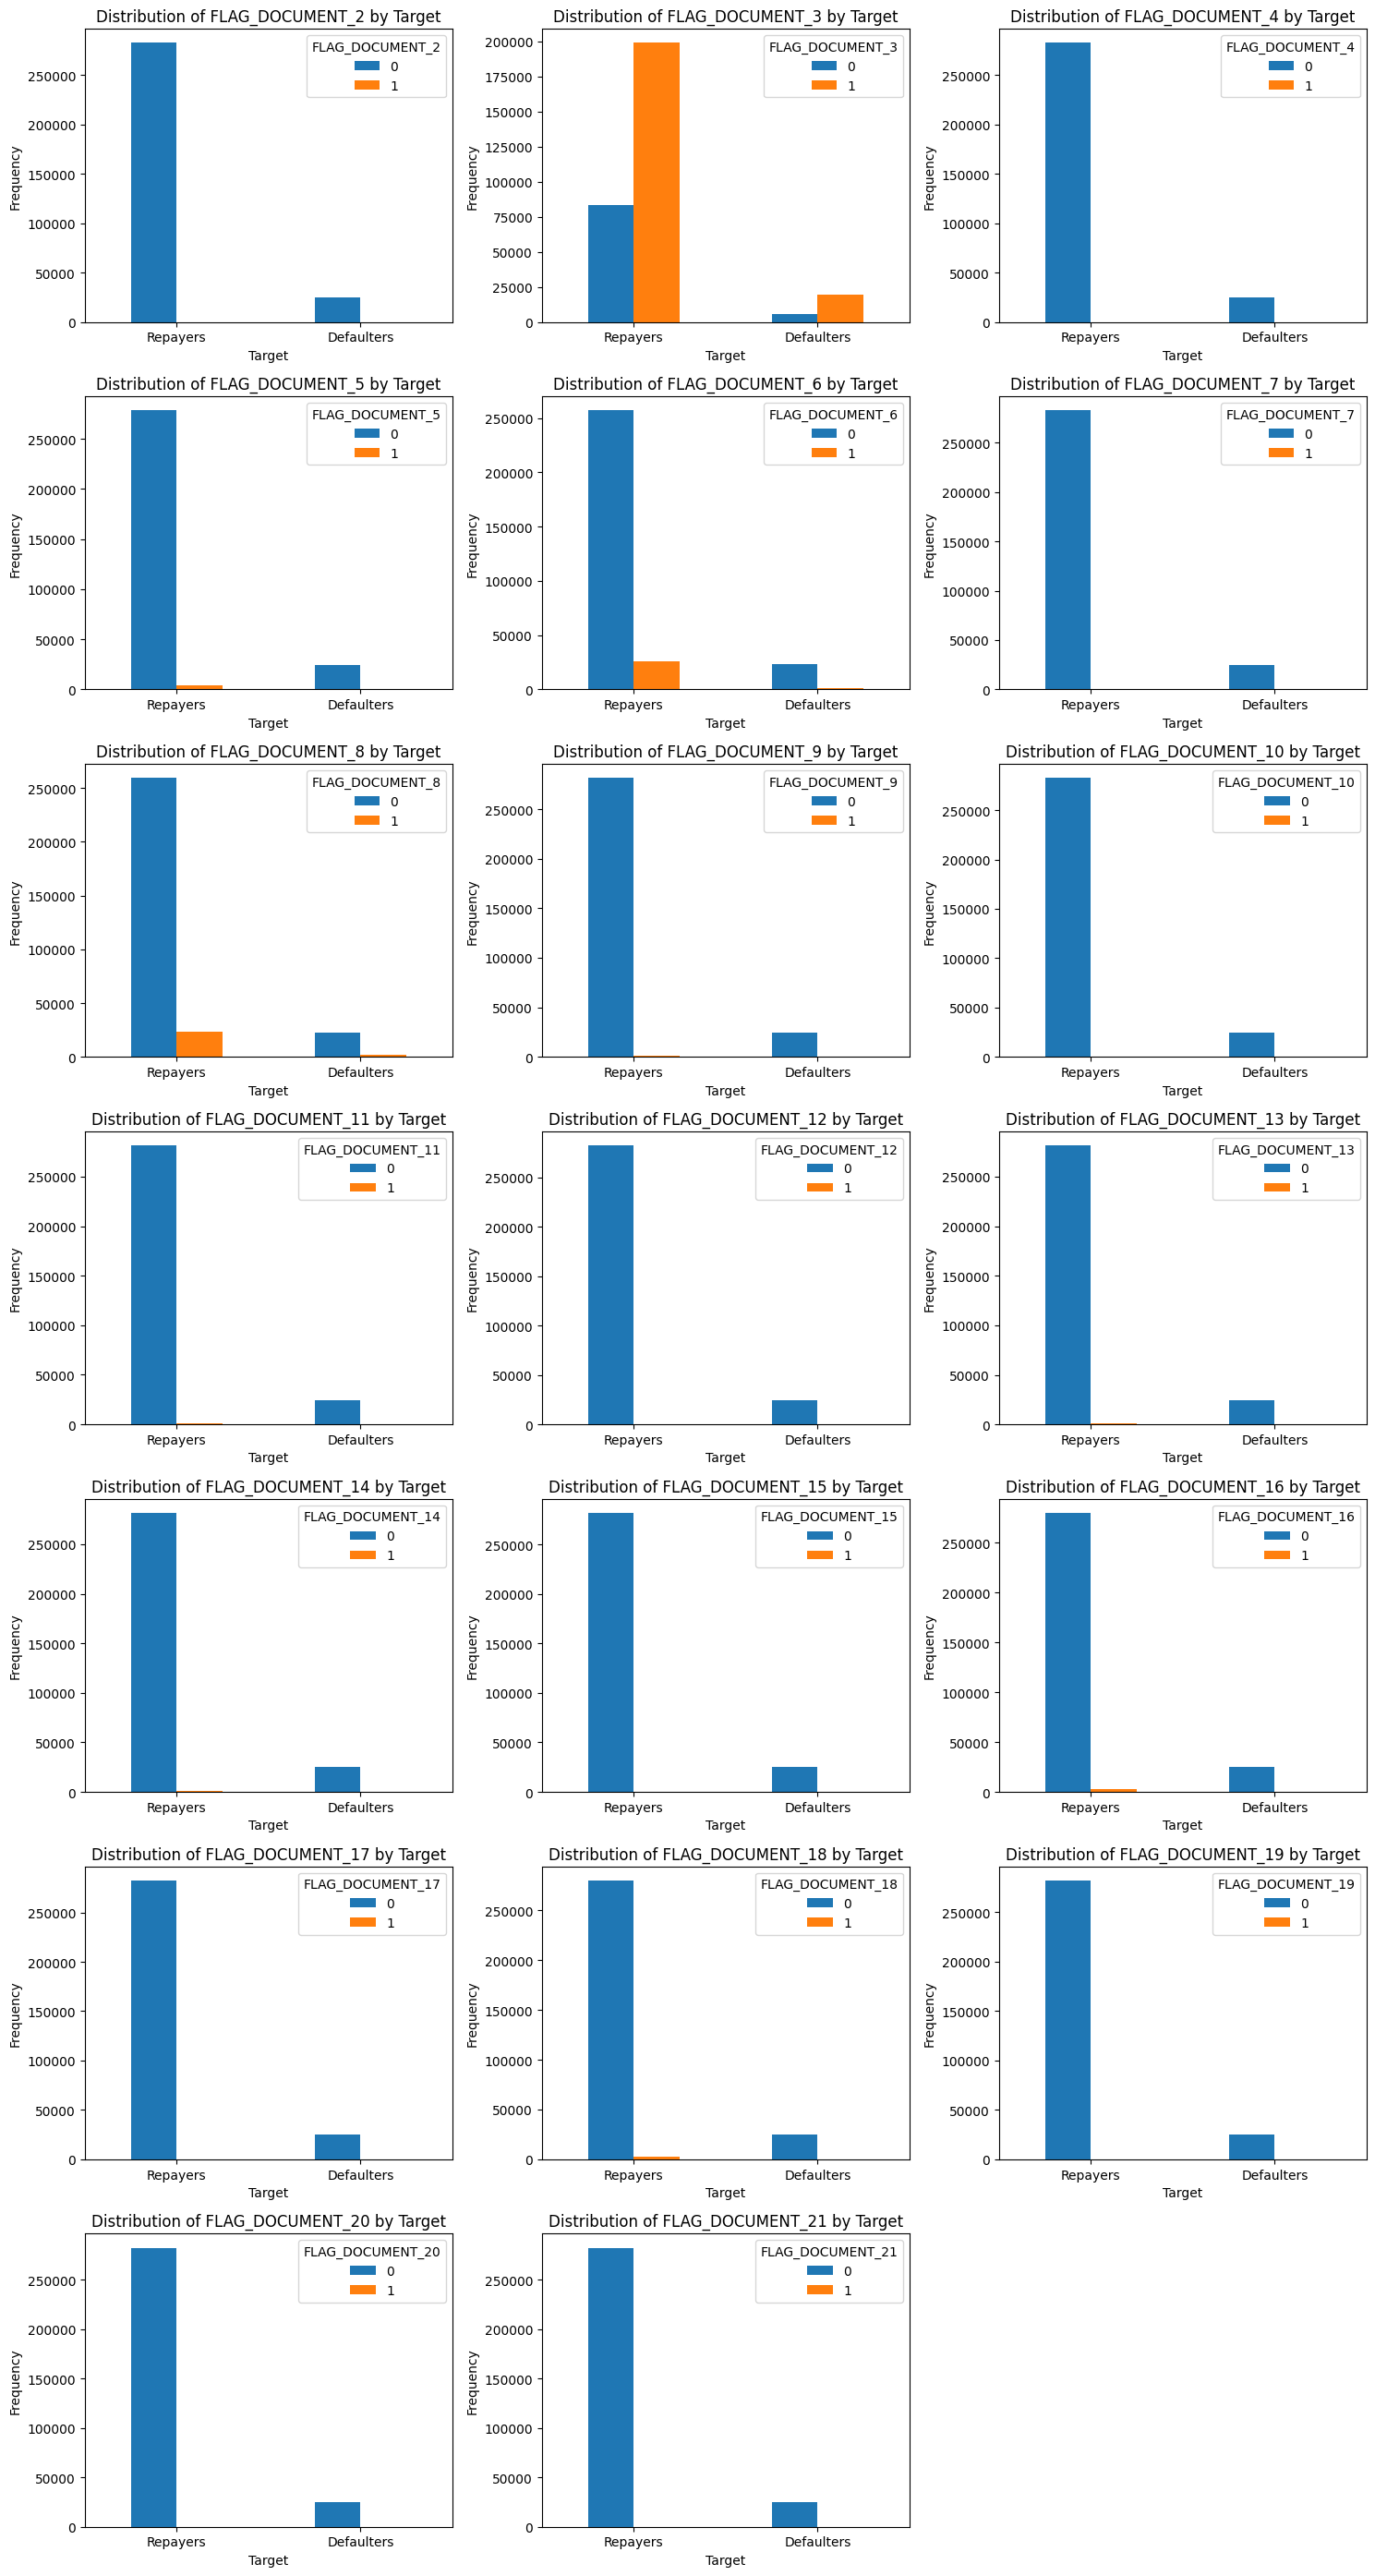

In [254]:
# Filter columns that contain 'FLAG_DOCUMENT'
document_flags = [col for col in app_df.columns if 'FLAG_DOCUMENT' in col]

# Determine the number of rows/columns for the subplot grid
n_rows = len(document_flags) // 3 + (len(document_flags) % 3 > 0)
n_cols = 3

# Create a figure and a grid of subplots
plt.figure(figsize=(15, n_rows * 4))

for index, column in enumerate(document_flags):
    plt.subplot(n_rows, n_cols, index + 1)
    
    # Create a DataFrame that contains counts of each category separated by the TARGET value
    flag_counts = app_df.groupby(['TARGET', column]).size().unstack(fill_value=0)
    
    # Plot the bar chart
    flag_counts.plot(kind='bar', stacked=False, ax=plt.gca())
    
    plt.title(f'Distribution of {column} by Target')
    plt.xlabel('Target')
    plt.ylabel('Frequency')
    plt.xticks(ticks=[0, 1], labels=['Repayers', 'Defaulters'], rotation=0)  # Assuming 0 is for repayers and 1 for defaulters
    plt.legend(title=column, labels=['0', '1'])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [255]:
flag_document_columns = [col for col in app_df.columns if 'FLAG_DOCUMENT' in col]
relevant_document_column = 'FLAG_DOCUMENT_3'
columns_to_remove.update([col for col in flag_document_columns if col != relevant_document_column])

print(len(columns_to_remove))

84


b. other flags

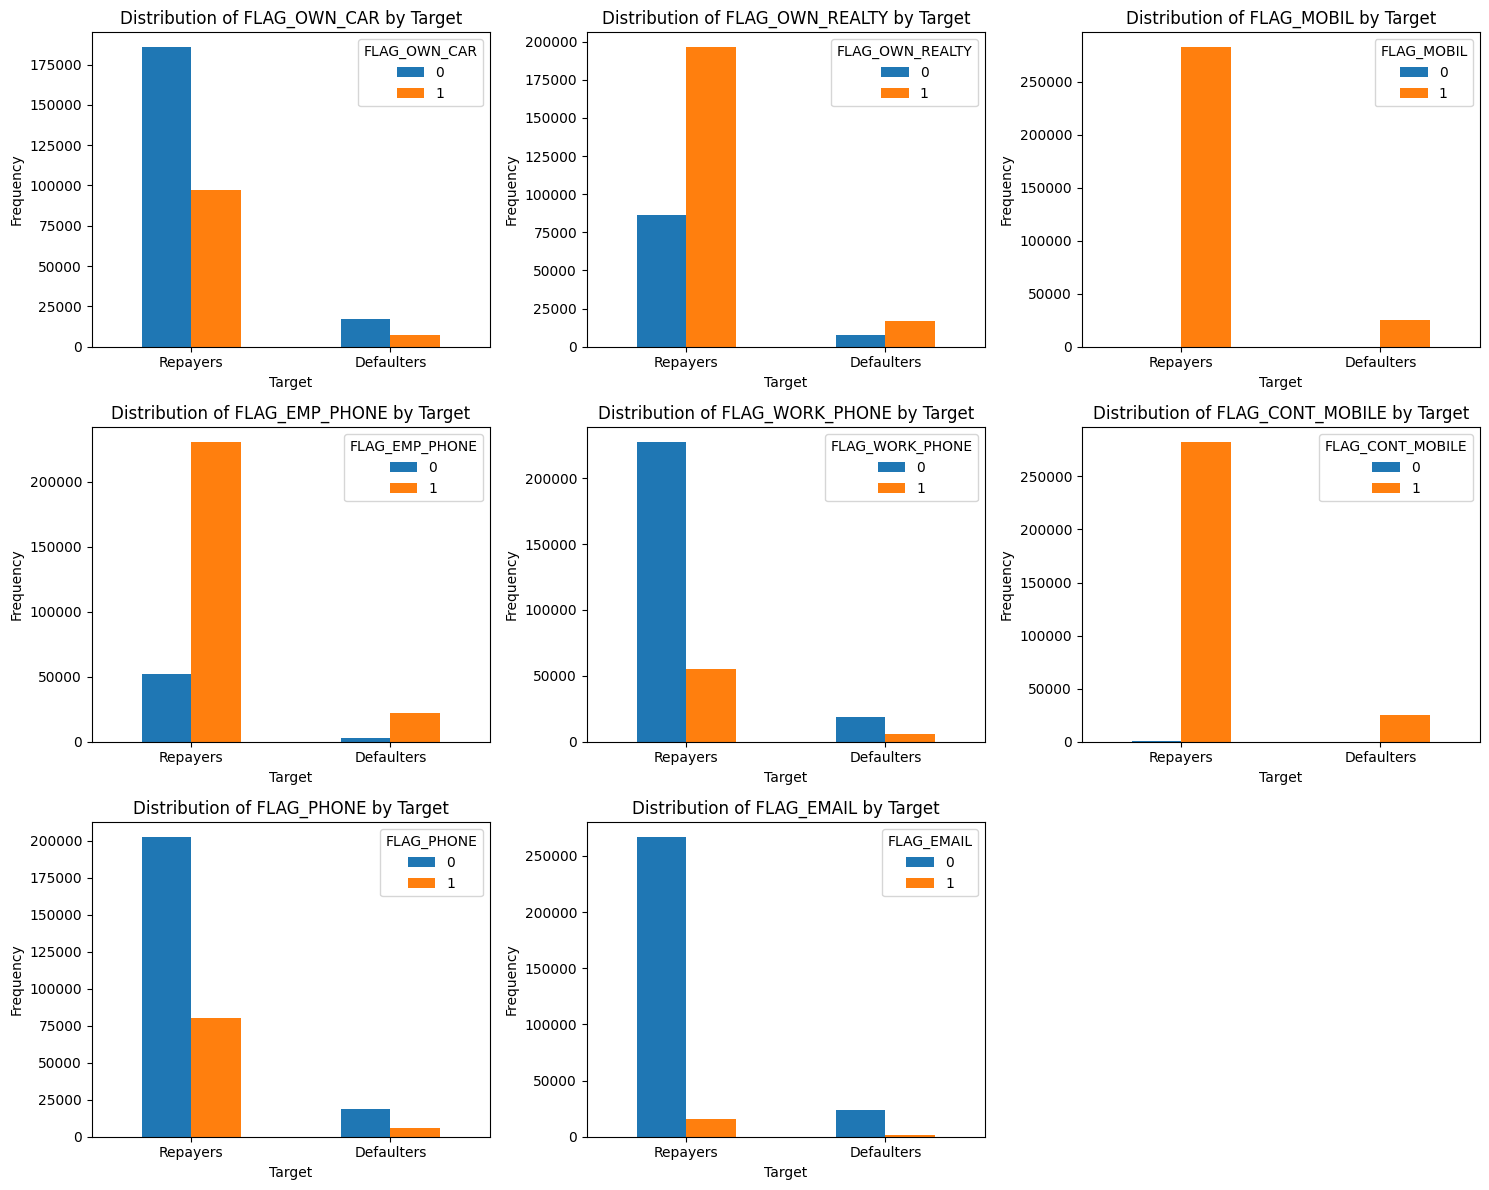

In [256]:
# Filter columns that contain 'FLAG_DOCUMENT'
flags = [col for col in app_df.columns if 'FLAG' in col and col not in document_flags]

# Determine the number of rows/columns for the subplot grid
n_rows = len(flags) // 3 + (len(flags) % 3 > 0)
n_cols = 3

# Create a figure and a grid of subplots
plt.figure(figsize=(15, n_rows * 4))

for index, column in enumerate(flags):
    plt.subplot(n_rows, n_cols, index + 1)
    
    # Create a DataFrame that contains counts of each category separated by the TARGET value
    flag_counts = app_df.groupby(['TARGET', column]).size().unstack(fill_value=0)
    
    # Plot the bar chart
    flag_counts.plot(kind='bar', stacked=False, ax=plt.gca())
    
    plt.title(f'Distribution of {column} by Target')
    plt.xlabel('Target')
    plt.ylabel('Frequency')
    plt.xticks(ticks=[0, 1], labels=['Repayers', 'Defaulters'], rotation=0)  # Assuming 0 is for repayers and 1 for defaulters
    plt.legend(title=column, labels=['0', '1'])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [257]:
columns_to_remove.update(['FLAG_MOBIL', 'FLAG_CONT_MOBILE'])
print(len(columns_to_remove))

84


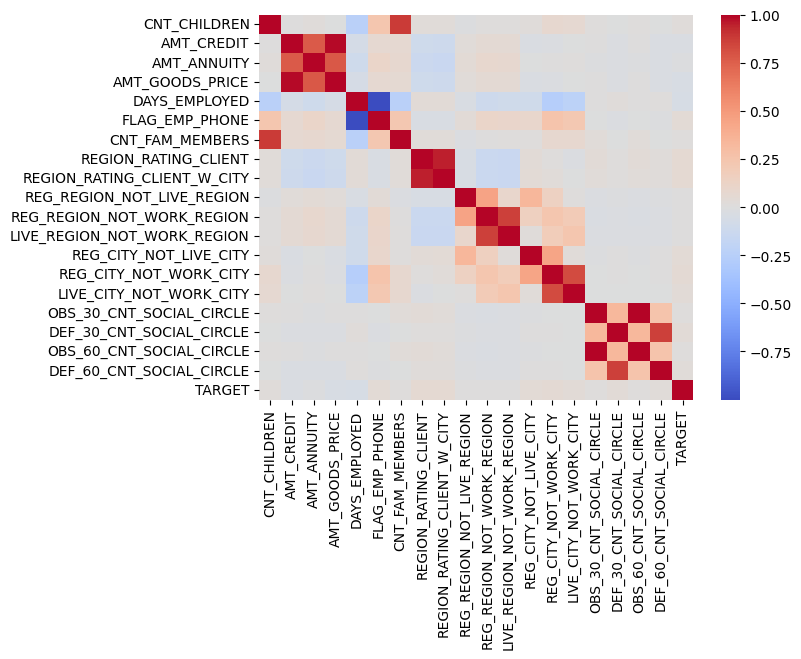

In [258]:
corr_columns = app_df[[ 'CNT_CHILDREN',
                        'AMT_CREDIT', 'AMT_ANNUITY' ,'AMT_GOODS_PRICE',
                        'DAYS_EMPLOYED',
                        'FLAG_EMP_PHONE' ,
                        'CNT_FAM_MEMBERS',
                        'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
                        'REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
                        'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
                        'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
                        'TARGET']]

correlation_matrix = corr_columns.corr()

plt.figure(figsize=(7, 5))

sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, annot=False)

plt.show()

In [259]:
columns_to_remove.update(['CNT_FAM_MEMBERS', 'FLAG_EMP_PHONE', 'REGION_RATING_CLIENT', 'LIVE_REGION_NOT_WORK_REGION', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY'])

print(len(columns_to_remove))

87


In [260]:
print(list(columns_to_remove))

['REG_REGION_NOT_WORK_REGION', 'AMT_INCOME_TOTAL', 'FLAG_DOCUMENT_19', 'BASEMENTAREA_MODE', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12', 'AMT_REQ_CREDIT_BUREAU_DAY', 'FLAG_DOCUMENT_11', 'ELEVATORS_MODE', 'OWN_CAR_AGE', 'APARTMENTS_MEDI', 'FLAG_CONT_MOBILE', 'CNT_FAM_MEMBERS', 'ENTRANCES_MEDI', 'NONLIVINGAREA_MODE', 'LIVINGAREA_MODE', 'LANDAREA_MEDI', 'DAYS_BIRTH', 'LIVINGAPARTMENTS_MODE', 'FLOORSMAX_MEDI', 'APARTMENTS_AVG', 'LANDAREA_AVG', 'OBS_30_CNT_SOCIAL_CIRCLE', 'FLAG_DOCUMENT_18', 'NONLIVINGAREA_AVG', 'FLAG_EMAIL', 'YEARS_BEGINEXPLUATATION_MODE', 'LIVINGAREA_AVG', 'FLOORSMIN_AVG', 'LANDAREA_MODE', 'FLAG_DOCUMENT_8', 'REG_CITY_NOT_LIVE_CITY', 'NONLIVINGAPARTMENTS_AVG', 'FLOORSMIN_MEDI', 'ENTRANCES_MODE', 'NONLIVINGAPARTMENTS_MODE', 'ENTRANCES_AVG', 'ELEVATORS_MEDI', 'FLAG_OWN_REALTY', 'FLAG_MOBIL', 'AMT_REQ_CREDIT_BUREAU_QRT', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_21', 'FLAG_DOCUMENT_6', 'YEARS_BUILD_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'FLOORSMAX_MODE', 'COMMONAREA_AVG', 'REGION_RATING

In [261]:
app_df_clean = app_df_cat.drop(columns=list(columns_to_remove))

#### 4.4 Outlier Detection and Treatment
important to find outliers before filling in missing data since outliers impact the distribution.

'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_MON'
<span style="color:lightgreen">*Note: these columns are mosty 0's and they show up in the outlier search. but since they're highly correlated with the data, i decided not to treat them as such. so i just excluded them altogether. no need to plot them really, they might be good for model training*</span>

In [262]:
# outlier detection
outlier_columns = find_outlier_columns(app_df_clean, multiplier=1.5, lower=0.05, upper=0.95, exclude=['DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_MON'])
print("Columns with outliers:", outlier_columns)


Columns with outliers: ['CNT_CHILDREN', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'AMT_REQ_CREDIT_BUREAU_YEAR']


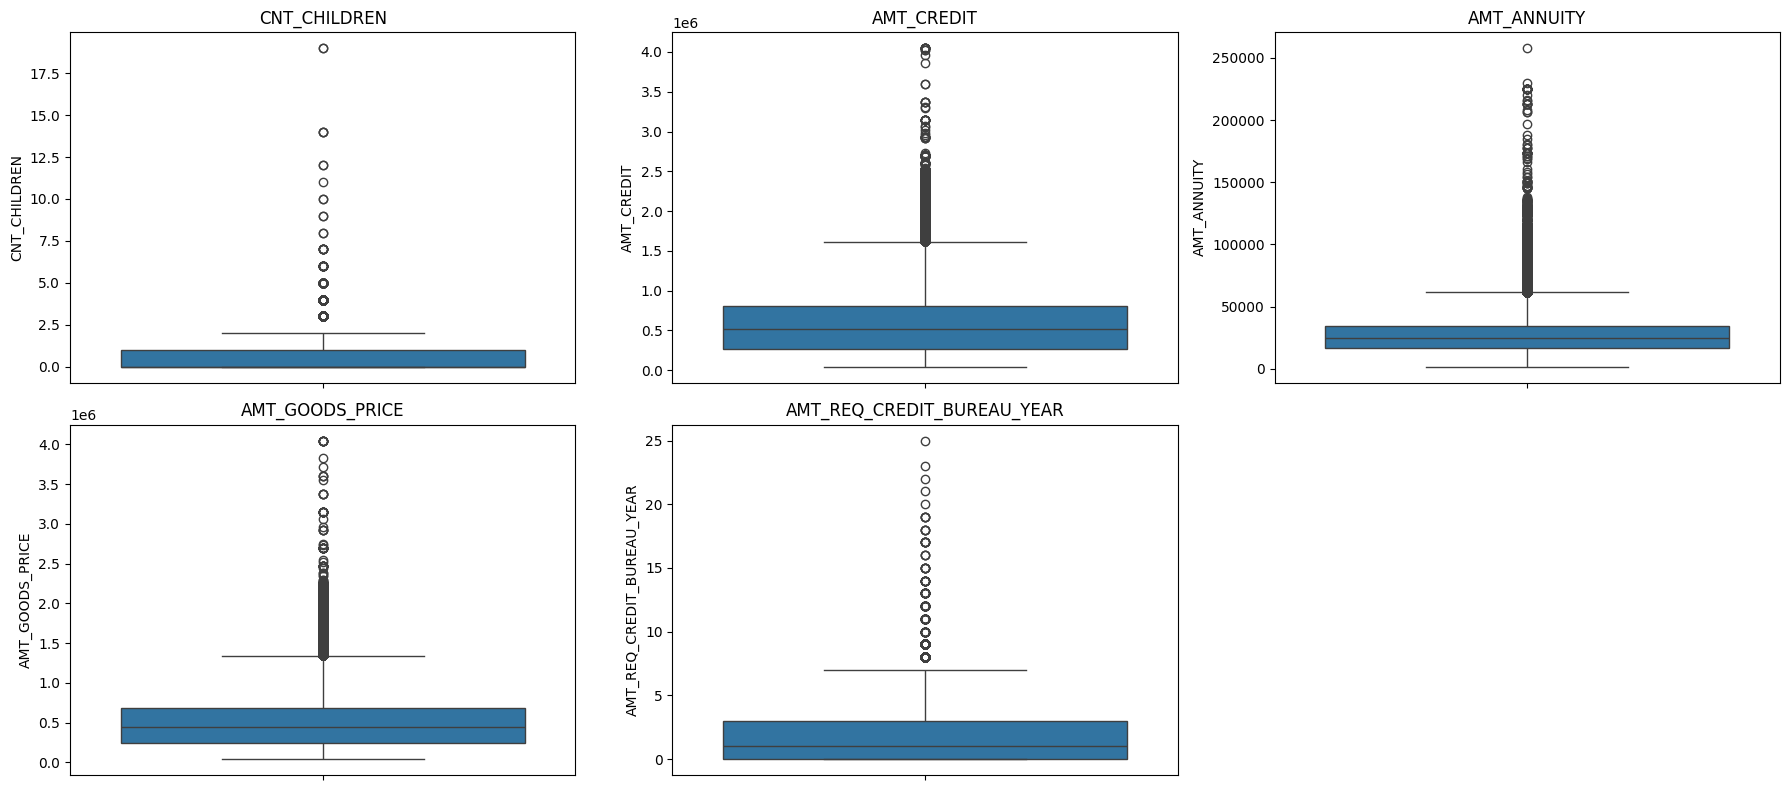

In [263]:
# Determine the number of rows/columns for the subplot grid
n_rows = len(outlier_columns) // 3 + (len(outlier_columns) % 3 > 0)
n_cols = 3

# Create a figure and a grid of subplots
plt.figure(figsize=(n_cols * 6, n_rows * 4))

for index, col in enumerate(outlier_columns):
    plt.subplot(n_rows, n_cols, index + 1)
    sns.boxplot(y=app_df_clean[col])
    plt.title(f'{col}')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [264]:
# Replace outliers with the median value of the column
for col in outlier_columns:
    Q1 = app_df_clean[col].quantile(0.25)
    Q3 = app_df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    median = app_df_clean[col].median()
    app_df_clean[col] = np.where((app_df_clean[col] < (Q1 - 1.5 * IQR)) | (app_df_clean[col] > (Q3 + 1.5 * IQR)), median, app_df_clean[col])


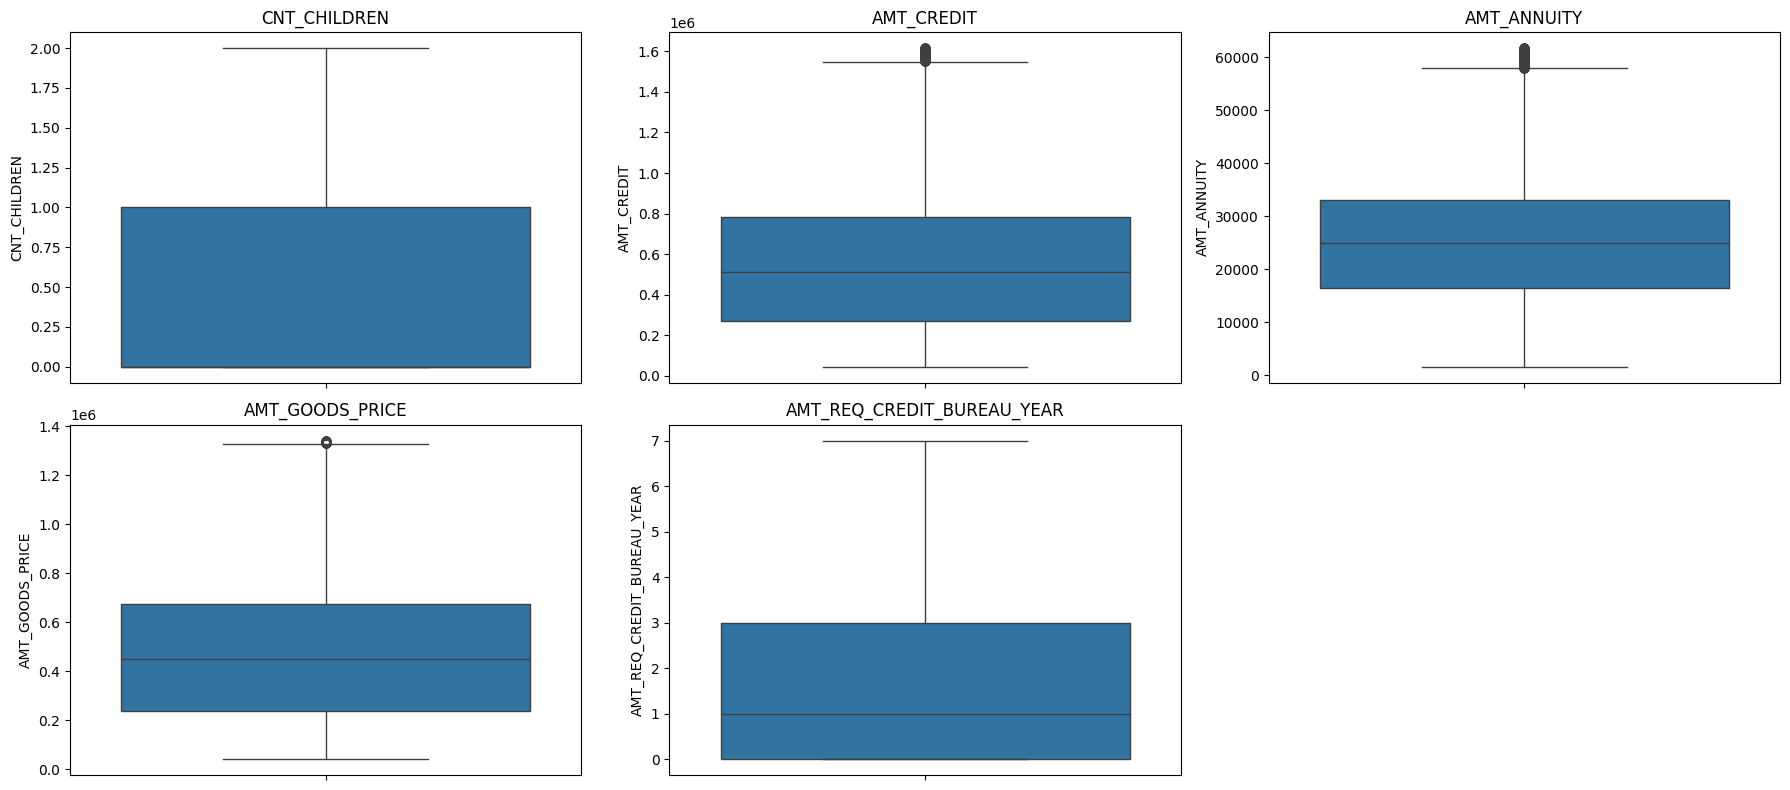

In [265]:
# Determine the number of rows/columns for the subplot grid
n_rows = len(outlier_columns) // 3 + (len(outlier_columns) % 3 > 0)
n_cols = 3

# Create a figure and a grid of subplots
plt.figure(figsize=(n_cols * 6, n_rows * 4))

for index, col in enumerate(outlier_columns):
    plt.subplot(n_rows, n_cols, index + 1)
    sns.boxplot(y=app_df_clean[col])
    plt.title(f'{col}')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

#### 4.5 Replacing missing data

In [266]:
categorical_cols_with_null = app_df_clean.select_dtypes(include=['category']).columns[app_df_clean.select_dtypes(include=['category']).isnull().any()].tolist()
print(categorical_cols_with_null)

['OCCUPATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']


In [267]:
# Replace null values in categorical columns with a new category 'missing'
for col in categorical_cols_with_null:
    app_df_clean[col] = app_df_clean[col].cat.add_categories('missing').fillna('missing')

In [268]:
# Find numerical columns with null values
numerical_cols_with_null = app_df_clean.select_dtypes(include=['float64', 'int64']).columns[app_df_clean.select_dtypes(include=['float64', 'int64']).isnull().any()].tolist()

In [269]:
# Replace null values in numerical columns with the median
for col in numerical_cols_with_null:
    app_df_clean[col] = app_df_clean[col].fillna(app_df_clean[col].median())

#### dataset check
must be non-negative, contains no null-values, has an appropriate number of features, only composed of int/float values


In [270]:
# Check for non-negative values
if (app_df_clean.select_dtypes(include=['int', 'float']) < 0).any().any():
    print("Data contains negative values.")
else:
    print("Data is non-negative.")

Data is non-negative.


In [271]:
# Check for null values
if app_df_clean.isnull().any().any():
    print("Data contains null values.")
else:
    print("Data contains no null-values.")

Data contains no null-values.


In [272]:
# Check for data types
if not all(dtype in ['int64', 'float64'] for dtype in app_df_clean.dtypes):
    print("Data contains non int/float values.")
else:
    print("All data is composed of int/float values.")

Data contains non int/float values.


In [273]:
app_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 36 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   TARGET                       307511 non-null  int64   
 1   NAME_CONTRACT_TYPE           307511 non-null  category
 2   CODE_GENDER                  307511 non-null  category
 3   FLAG_OWN_CAR                 307511 non-null  category
 4   CNT_CHILDREN                 307511 non-null  float64 
 5   AMT_CREDIT                   307511 non-null  float64 
 6   AMT_ANNUITY                  307511 non-null  float64 
 7   AMT_GOODS_PRICE              307511 non-null  float64 
 8   NAME_INCOME_TYPE             307511 non-null  category
 9   NAME_EDUCATION_TYPE          307511 non-null  category
 10  NAME_HOUSING_TYPE            307511 non-null  category
 11  REGION_POPULATION_RELATIVE   307511 non-null  float64 
 12  DAYS_EMPLOYED                307511 non-null

### 5 Exploratory Data Analysis (EDA)

#### 5.1 Univariate Analysis

It involves examining the distribution and characteristics of a single variable at a time. It's a fundamental step in exploratory data analysis (EDA) to understand the individual features of the dataset before diving into more complex analyses. </br>
Let's first visualize simple info in the dataset, studying social, finantial, professional aspects of the clients and see if we get relevant descriptions of the customers by doing that.

Text(0, 0.5, 'Amount')

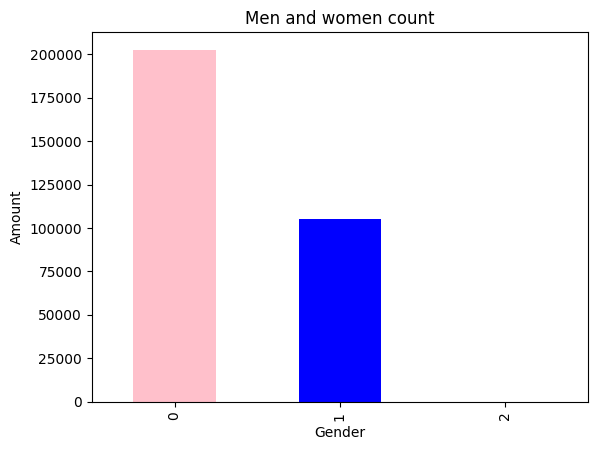

In [289]:
gender_count = app_df_clean[app_df_clean['CODE_GENDER'] != 'XNA']['CODE_GENDER'].value_counts() # using df to have categorical values
gender_count.plot(kind='bar', color=['pink', 'blue'])
plt.title('Men and women count')
plt.xlabel('Gender')
plt.ylabel('Amount')

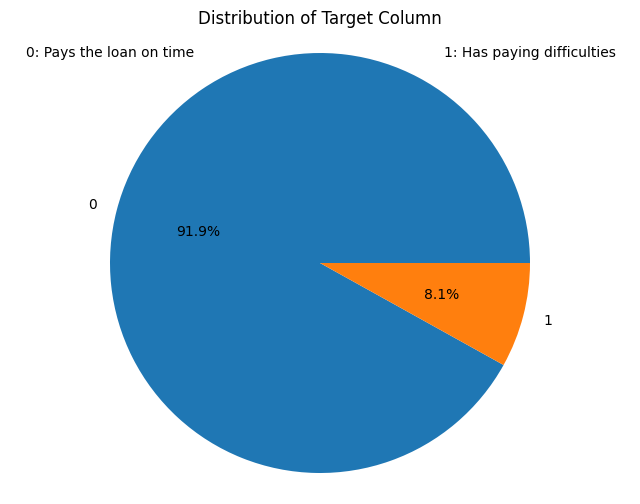

In [290]:
plt.figure(figsize=(8, 6))

# Count the occurrences of each target value
target_counts = app_df_clean['TARGET'].value_counts()

target_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Target Column')
plt.ylabel('')  # Remove y-label
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Adding subtitles for each category
plt.text(-1, 1, '0: Pays the loan on time', horizontalalignment='center', verticalalignment='center')
plt.text(1, 1, '1: Has paying difficulties', horizontalalignment='center', verticalalignment='center')

plt.show()

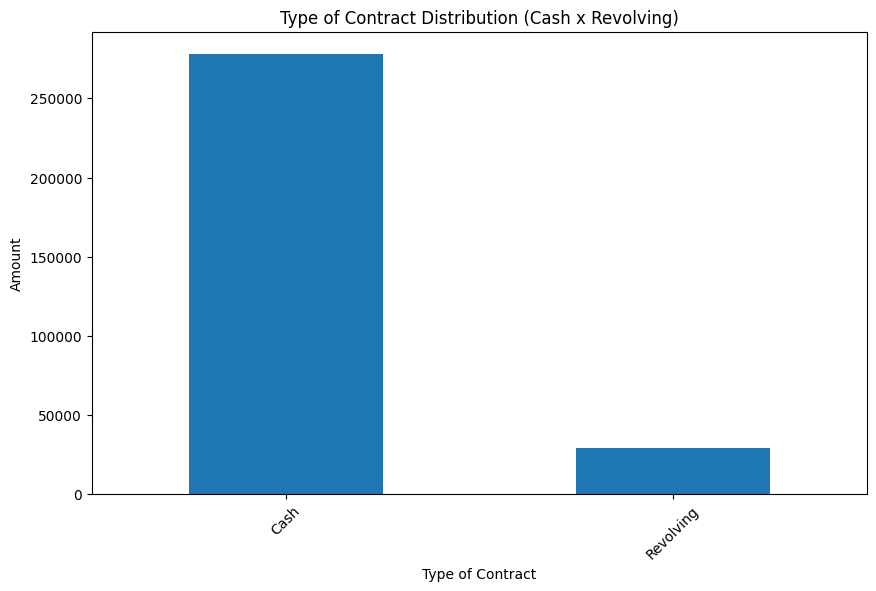

In [291]:
# Count occurrences of each value in NAME_CONTRACT_TYPE
contract_type_counts = app_df_clean['NAME_CONTRACT_TYPE'].value_counts()

# Map the values to the desired labels
contract_type_labels = {0: 'Cash', 1: 'Revolving'}

# Replace the labels in DF index
contract_type_counts.index = contract_type_counts.index.map(contract_type_labels)

# Plot
plt.figure(figsize=(10, 6))
contract_type_counts.plot(kind='bar')
plt.title('Type of Contract Distribution (Cash x Revolving)')
plt.xlabel('Type of Contract')
plt.ylabel('Amount')
plt.xticks(rotation=45)  # Rotate axis-x labels for better readability
plt.show()

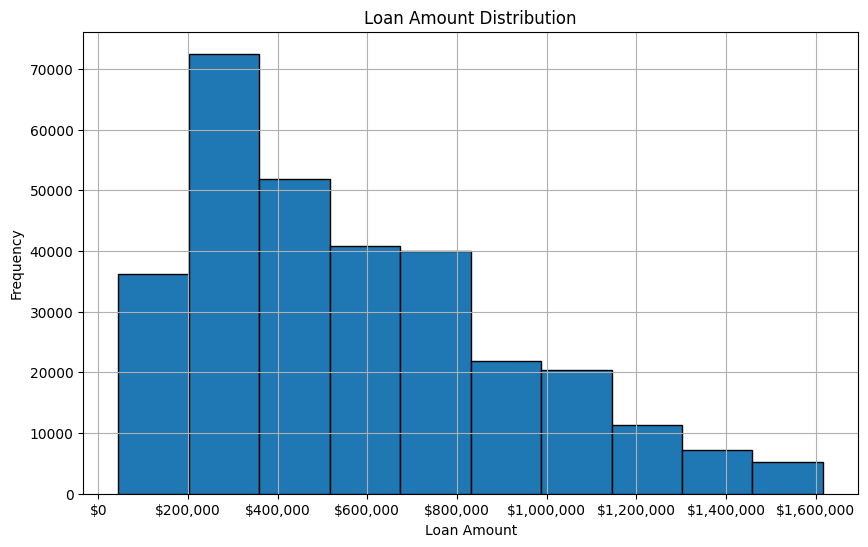

In [294]:
import matplotlib.ticker as ticker
plt.figure(figsize=(10, 6))
plt.hist(app_df_clean['AMT_CREDIT'], bins=10, edgecolor='black')
plt.title('Loan Amount Distribution')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.grid(True)

# Format x-axis ticks as monetary values
formatter = ticker.StrMethodFormatter('${x:,.0f}')
plt.gca().xaxis.set_major_formatter(formatter)

plt.show()

#### 5.2 Bivariate Analysis

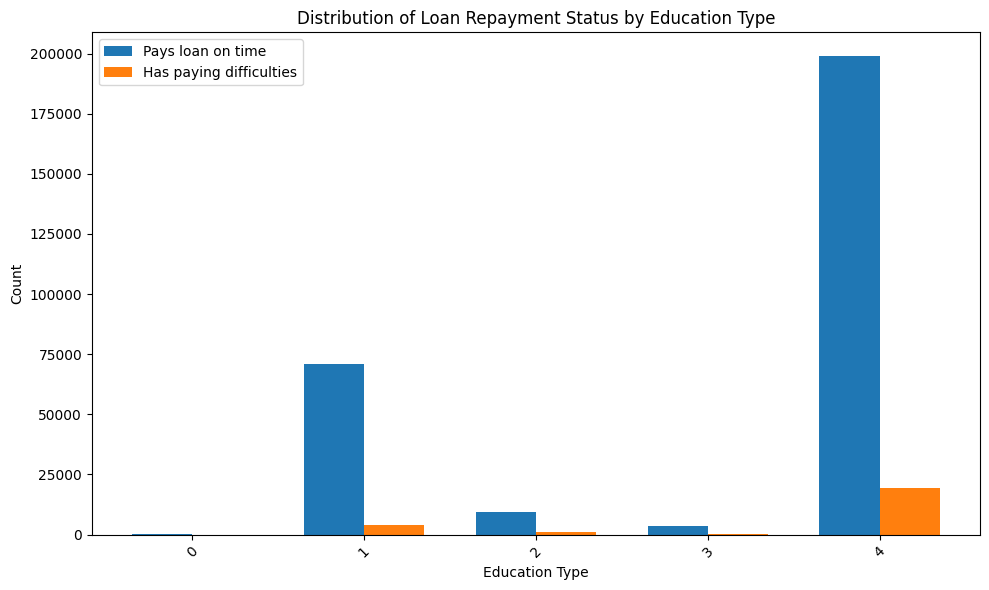

In [296]:
# Grouping by 'NAME_EDUCATION_TYPE' and 'TARGET' and counting occurrences
grouped_data = app_df_clean.groupby(['NAME_EDUCATION_TYPE', 'TARGET']).size().unstack()

# Plotting
plt.figure(figsize=(10, 6))

# Bar width
bar_width = 0.35

# Positions for bars
index = range(len(grouped_data))

# Plotting bars for 'TARGET' = 0 (Pays loan on time)
plt.bar(index, grouped_data[0], bar_width, label='Pays loan on time')

# Plotting bars for 'TARGET' = 1 (Has paying difficulties)
plt.bar([i + bar_width for i in index], grouped_data[1], bar_width, label='Has paying difficulties')

# Adding labels, title, and legend
plt.xlabel('Education Type')
plt.ylabel('Count')
plt.title('Distribution of Loan Repayment Status by Education Type')
plt.xticks([i + bar_width/2 for i in index], grouped_data.index, rotation=45)
plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

### 6 Data augmentation and model training (with Oversampling and Undersampling)

#### 6.1 Hybrid Balancing

In [280]:
from sklearn.preprocessing import LabelEncoder

# Identify all categorical columns in the DataFrame
categorical_cols = app_df_clean.select_dtypes(include=['category', 'object']).columns.tolist()

# Apply Label Encoding to each categorical column
label_encoder = LabelEncoder()

for col in categorical_cols:
    app_df_clean[col] = label_encoder.fit_transform(app_df_clean[col])

In [281]:
app_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 36 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   TARGET                       307511 non-null  int64  
 1   NAME_CONTRACT_TYPE           307511 non-null  int32  
 2   CODE_GENDER                  307511 non-null  int32  
 3   FLAG_OWN_CAR                 307511 non-null  int32  
 4   CNT_CHILDREN                 307511 non-null  float64
 5   AMT_CREDIT                   307511 non-null  float64
 6   AMT_ANNUITY                  307511 non-null  float64
 7   AMT_GOODS_PRICE              307511 non-null  float64
 8   NAME_INCOME_TYPE             307511 non-null  int32  
 9   NAME_EDUCATION_TYPE          307511 non-null  int32  
 10  NAME_HOUSING_TYPE            307511 non-null  int32  
 11  REGION_POPULATION_RELATIVE   307511 non-null  float64
 12  DAYS_EMPLOYED                307511 non-null  int64  
 13 

In [282]:
from imblearn.under_sampling import TomekLinks
from collections import Counter

X = app_df_clean.drop(columns=['TARGET'])
y = app_df_clean['TARGET']

#### 6.2 Training using Decision tree

In [283]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.metrics import accuracy_score, recall_score, f1_score
import numpy as np

max_depth = 30
undersampling_ratio = 0.4
oversampling_ratio = 0.5

# Initialize the DecisionTree model
dt_model = DecisionTreeClassifier(max_depth=max_depth)

# Define the number of folds for cross-validation
num_folds = 5

# Initialize lists to store scores
accuracy_scores = []
recall_class_0_scores = []
recall_class_1_scores = []
f1_class_0_scores = []
f1_class_1_scores = []

# Initialize the k-fold cross-validator
cv = StratifiedKFold(n_splits=num_folds, shuffle=False)

# Loop over each fold of cross-validation
for train_index, test_index in cv.split(X, y):
    # Split data into train and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply NearMiss to training set...
    near_miss = NearMiss(version=1, sampling_strategy=undersampling_ratio)
    X_train_under, y_train_under = near_miss.fit_resample(X_train, y_train)
    # ... and then SMOTE oversampling on it also
    smote = SMOTE(sampling_strategy=oversampling_ratio, random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_under, y_train_under)

    # Train the DecisionTree model on the balanced train set
    dt_model.fit(X_train_balanced, y_train_balanced)

    # Make predictions on the original test set
    y_pred = dt_model.predict(X_test)

    # Calculate evaluation metrics
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    recall_class_0_scores.append(recall_score(y_test, y_pred, pos_label=0))
    recall_class_1_scores.append(recall_score(y_test, y_pred, pos_label=1))
    f1_class_0_scores.append(f1_score(y_test, y_pred, pos_label=0))
    f1_class_1_scores.append(f1_score(y_test, y_pred, pos_label=1))

# Calculate the mean and standard deviation of each metric
accuracy_mean = np.mean(accuracy_scores)
accuracy_std = np.std(accuracy_scores)
recall_class_0_mean = np.mean(recall_class_0_scores)
recall_class_0_std = np.std(recall_class_0_scores)
recall_class_1_mean = np.mean(recall_class_1_scores)
recall_class_1_std = np.std(recall_class_1_scores)
f1_class_0_mean = np.mean(f1_class_0_scores)
f1_class_0_std = np.std(f1_class_0_scores)
f1_class_1_mean = np.mean(f1_class_1_scores)
f1_class_1_std = np.std(f1_class_1_scores)

# Print the means and standard deviations of each metric
print("Accuracy: {:.4f} +- {:.4f}".format(accuracy_mean, accuracy_std))
print("Recall Class 0: {:.4f} +- {:.4f}".format(recall_class_0_mean, recall_class_0_std))
print("Recall Class 1: {:.4f} +- {:.4f}".format(recall_class_1_mean, recall_class_1_std))
print("F1-Score Class 0: {:.4f} +- {:.4f}".format(f1_class_0_mean, f1_class_0_std))
print("F1-Score Class 1: {:.4f} +- {:.4f}".format(f1_class_1_mean, f1_class_1_std))

Accuracy: 0.4870 +- 0.0145
Recall Class 0: 0.4800 +- 0.0166
Recall Class 1: 0.5663 +- 0.0129
F1-Score Class 0: 0.6322 +- 0.0148
F1-Score Class 1: 0.1513 +- 0.0024


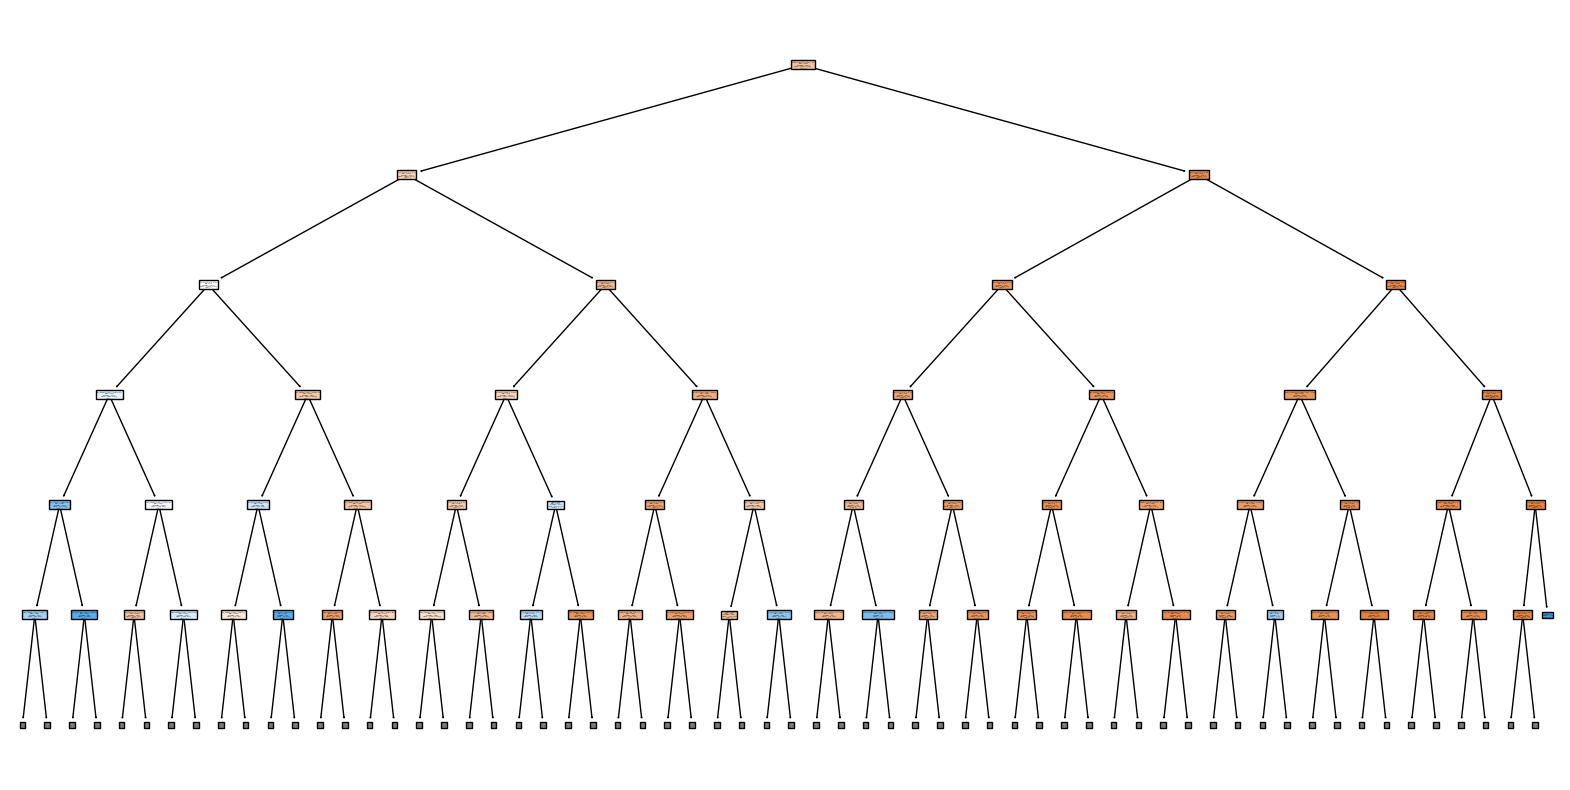

In [284]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(dt_model, max_depth=5, feature_names=X.columns, class_names=['0', '1'], filled=True)
plt.show()

#### 6.3 Training using Random forest

In [286]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import NearMiss
from sklearn.metrics import accuracy_score, recall_score, f1_score
import numpy as np

n_estimators =  200
max_depth = 30
undersampling_ratio = 0.4
oversampling_ratio = 0.5

# Initialize the RandomForest model
rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)

# Define the number of folds for cross-validation
num_folds = 5

# Initialize lists to store scores
accuracy_scores = []
recall_class_0_scores = []
recall_class_1_scores = []
f1_class_0_scores = []
f1_class_1_scores = []

# Initialize the k-fold cross-validator
cv = StratifiedKFold(n_splits=num_folds, shuffle=False)

# Loop over each fold of cross-validation
for train_index, test_index in cv.split(X, y):
    # Split data into train and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply NearMiss to training set...
    near_miss = NearMiss(version=1, sampling_strategy=undersampling_ratio)
    X_train_under, y_train_under = near_miss.fit_resample(X_train, y_train)
    # ... and then SMOTE oversampling on it also
    smote = SMOTE(sampling_strategy=oversampling_ratio, random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_under, y_train_under)
    # ... ADASYN oversampling
    adasyn = ADASYN(sampling_strategy='auto', random_state=42)
    X_train_balanced_adasyn, y_train_balanced_adasyn = adasyn.fit_resample(X_train_balanced, y_train_balanced)

    # Train the RandomForest model on the balanced train set
    rf_model.fit(X_train_balanced_adasyn, y_train_balanced_adasyn)

    # Make predictions on the original test set
    y_pred = rf_model.predict(X_test)

    # Calculate evaluation metrics
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    recall_class_0_scores.append(recall_score(y_test, y_pred, pos_label=0))
    recall_class_1_scores.append(recall_score(y_test, y_pred, pos_label=1))
    f1_class_0_scores.append(f1_score(y_test, y_pred, pos_label=0))
    f1_class_1_scores.append(f1_score(y_test, y_pred, pos_label=1))

# Calculate the mean and standard deviation of each metric
accuracy_mean = np.mean(accuracy_scores)
accuracy_std = np.std(accuracy_scores)
recall_class_0_mean = np.mean(recall_class_0_scores)
recall_class_0_std = np.std(recall_class_0_scores)
recall_class_1_mean = np.mean(recall_class_1_scores)
recall_class_1_std = np.std(recall_class_1_scores)
f1_class_0_mean = np.mean(f1_class_0_scores)
f1_class_0_std = np.std(f1_class_0_scores)
f1_class_1_mean = np.mean(f1_class_1_scores)
f1_class_1_std = np.std(f1_class_1_scores)

# Print the means and standard deviations of each metric
print("Accuracy: {:.4f} +- {:.4f}".format(accuracy_mean, accuracy_std))
print("Recall Class 0: {:.4f} +- {:.4f}".format(recall_class_0_mean, recall_class_0_std))
print("Recall Class 1: {:.4f} +- {:.4f}".format(recall_class_1_mean, recall_class_1_std))
print("F1-Score Class 0: {:.4f} +- {:.4f}".format(f1_class_0_mean, f1_class_0_std))
print("F1-Score Class 1: {:.4f} +- {:.4f}".format(f1_class_1_mean, f1_class_1_std))

Accuracy: 0.6674 +- 0.0049
Recall Class 0: 0.6860 +- 0.0057
Recall Class 1: 0.4559 +- 0.0065
F1-Score Class 0: 0.7913 +- 0.0038
F1-Score Class 1: 0.1812 +- 0.0019


In [287]:
from collections import Counter
counter_train_balanced_adasyn = Counter(y_train_balanced_adasyn)
print("Class distribution after hybrid sampling:", counter_train_balanced_adasyn)

Class distribution after hybrid sampling: Counter({0: 49650, 1: 45521})


#### 6.4 Training using SVC

In [288]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.metrics import accuracy_score, recall_score, f1_score
import numpy as np

kernel='rbf'
undersampling_ratio = 0.4
oversampling_ratio = 0.5

# Initialize the SVC model
svc_model = SVC(kernel='rbf')

# Define the number of folds for cross-validation
num_folds = 5

# Initialize lists to store scores
accuracy_scores = []
recall_class_0_scores = []
recall_class_1_scores = []
f1_class_0_scores = []
f1_class_1_scores = []

# Initialize the k-fold cross-validator
cv = StratifiedKFold(n_splits=num_folds, shuffle=False)

# Loop over each fold of cross-validation
for train_index, test_index in cv.split(X, y):
    # Split data into train and test sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply NearMiss to training set...
    near_miss = NearMiss(version=1, sampling_strategy=undersampling_ratio)
    X_train_under, y_train_under = near_miss.fit_resample(X_train, y_train)
    # ... and then SMOTE oversampling on it also
    smote = SMOTE(sampling_strategy=oversampling_ratio, random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_under, y_train_under)

    # Train the SVC model on the balanced train set
    svc_model.fit(X_train_balanced, y_train_balanced)  # Substituir rf_model por svc_model

    # Make predictions on the original test set
    y_pred = svc_model.predict(X_test)  # Substituir rf_model por svc_model

    # Calculate evaluation metrics
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    recall_class_0_scores.append(recall_score(y_test, y_pred, pos_label=0))
    recall_class_1_scores.append(recall_score(y_test, y_pred, pos_label=1))
    f1_class_0_scores.append(f1_score(y_test, y_pred, pos_label=0))
    f1_class_1_scores.append(f1_score(y_test, y_pred, pos_label=1))

# Calculate the mean and standard deviation of each metric
accuracy_mean = np.mean(accuracy_scores)
accuracy_std = np.std(accuracy_scores)
recall_class_0_mean = np.mean(recall_class_0_scores)
recall_class_0_std = np.std(recall_class_0_scores)
recall_class_1_mean = np.mean(recall_class_1_scores)
recall_class_1_std = np.std(recall_class_1_scores)
f1_class_0_mean = np.mean(f1_class_0_scores)
f1_class_0_std = np.std(f1_class_0_scores)
f1_class_1_mean = np.mean(f1_class_1_scores)
f1_class_1_std = np.std(f1_class_1_scores)

# Print the means and standard deviations of each metric
print("Accuracy: {:.4f} +- {:.4f}".format(accuracy_mean, accuracy_std))
print("Recall Class 0: {:.4f} +- {:.4f}".format(recall_class_0_mean, recall_class_0_std))
print("Recall Class 1: {:.4f} +- {:.4f}".format(recall_class_1_mean, recall_class_1_std))
print("F1-Score Class 0: {:.4f} +- {:.4f}".format(f1_class_0_mean, f1_class_0_std))
print("F1-Score Class 1: {:.4f} +- {:.4f}".format(f1_class_1_mean, f1_class_1_std))

Accuracy: 0.9019 +- 0.0012
Recall Class 0: 0.9800 +- 0.0014
Recall Class 1: 0.0129 +- 0.0018
F1-Score Class 0: 0.9484 +- 0.0007
F1-Score Class 1: 0.0208 +- 0.0026
